# K-Prototype For Enrollment

This model deployment is for the marketing team to see not only where we should target for geofencing, but also with what. Given the sheer number of programs, it is good for us to know who the students are, where they live, their age, etc. and use that information for targeted marketing when possible. Therefore, with a combination of using a K-Prototype algorithm and applying the Haversine formula, I was able to show the unique clusters of our students and, in the interactive map I created, allow for filtering based on distance from the college.

In [9]:
import numpy as np
import pandas as pd

# Import module for data visualization
from plotnine import *
import plotnine

# Import module for k-prototype cluster
from kmodes.kprototypes import KPrototypes

# Format scientific notation from Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore")


import os
from pathlib import Path
from dotenv import load_dotenv

import json
import logging
import sys


import ipytest

# Creating a path to a folder called "code" to save temporal scripts in that folder
CODE_FOLDER = Path("code") 
CODE_FOLDER.mkdir(exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}"])

# File Directory
DATA_FILEPATH = 'Files'


In [10]:
%%html
<style>
table {float:left}
</style>

In [11]:
# Load data, 
enroll = (pd.read_csv(DATA_FILEPATH + '/202110 - 202280 FA, SP, SU HC 20th-D.csv', encoding = 'cp1252')
              .rename(columns = str.lower)
         )

# For practice, isolate a single semester as the K-Prototype Altorithm is time intensive
enroll = enroll[enroll['term'] == 202110]

# Sort values by term and id
enroll.sort_values(['term', 'id'], ascending = [True, True]).reset_index(drop = True, inplace = True)
 

## Data Exploration

In [12]:
# Examine missing data
miss_data = pd.DataFrame({'# missing':enroll.isna().sum()})

miss_data['% rep missing'] = enroll.isna().sum()/len(enroll) * 100

miss_data

# missing  % rep missing
term                0          0.000
pidm                0          0.000
age                 0          0.000
id                  0          0.000
lname               0          0.000
fname               0          0.000
mi               2495         38.197
totcr               0          0.000
status              0          0.000
stype               0          0.000
rescode             0          0.000
resd_desc           0          0.000
degcode             0          0.000
degree              0          0.000
majr                0          0.000
majr_desc1          0          0.000
gender              0          0.000
mrtl             3392         51.929
ecode             358          5.481
race_desc         506          7.746
ethn_desc         358          5.481
cnty               41          0.628
cnty_desc1         41          0.628
addr#               0          0.000
edgoal           4002         61.268
goaldesc         4002         61.268
program             0          0.000
dob                 0          0.000
confid            178          2.725

### Columns To Eliminate Or Impute

* *pidm*, *lname*, *fname*, *mi*, *rescode*, *degcode*, *majr*, *mrtl*, *ecode*, *race_desc*, *cnty*, *addr#*, *edgoal*, *goaldesc*, *program*, *dob*, *confid*
    * Remove all of these because they are either unnecessary for the k-prototype algorithm or repetitive
* *age*: Missing just one value. Therefore, enroll['age'].isna() == False
* *gender*: Missing just five values. Therefore, enroll['gender'].isna() == False
* *cnty_desc1*: Missing 165 values (0.432%). Therefore, enroll['cnty_desc1'].isna() == False
* *ethn_desc*: Missing 1725 values, 4.514%. Therefore, I will create an additional category, in essence, 'missing'.
* *mrtl*: While there may be some benefit in predictive analysis with the marital status of the individual, we are missing nearly 62% of the entries, which is too much to impute given its a categorical variable. It is unclear what value could be derived from the remaining 38%. After completing the first run through, I might add this variable back in to see if the modeling produces any more insights.

In [ ]:
# Pare down dataframe based on criteria above
enroll = enroll[['id', 'term', 'age', 'totcr', 'status', 'stype', 'resd_desc', 'degree',
                 'majr_desc1', 'gender', 'ethn_desc', 'cnty_desc1']]

# Fill missing values for *ethn_desc* with 'missing', effectively creating
# a new category
enroll['ethn_desc'] = enroll['ethn_desc'].fillna('missing')

# Change the *term* column to a category as it is not actually an 
# integer
enroll['term'] = enroll['term'].astype('str')

# Filter out the NaN values as there were not enough to warrant
# data imputation
mask1 = enroll['age'].isna() == False
mask2 = enroll['gender'].isna() == False
mask3 = enroll['cnty_desc1'].isna() == False

enroll = enroll[mask1 & mask2 & mask3]

## The Data

After removing the extraneous data and addressing missing values, we are left with 38044 observations and 12 columns. The model will be ran without the *id* column as it will provide no predictive value. The *term* column will be used as a filter to assess whether the clusters of students who enroll vary depending on the semester (i.e. Fall vs. Spring semester). Beyond these two columns, the features are as follows:

There are eight categorical variables and two float variables. The float variables will be centered and scaled. The categorical variables will be separated into indicator variables.

Let's inspect the nature of the categorical variables.


In [13]:
# Identify the number of unique values for each category, ignoring
# the 'id' and 'term' column
enroll.select_dtypes('object').nunique()


id            6532
lname         4025
fname         2583
mi            1347
status           4
stype            6
rescode          8
resd_desc        8
degcode         10
degree          10
majr            91
majr_desc1      91
gender           3
mrtl             4
ecode            8
race_desc        9
ethn_desc        8
cnty           237
cnty_desc1     221
edgoal           6
goaldesc         6
program         64
dob           3747
confid           2
dtype: int64

### Examine the numerical data

.desribe() naturally isolates the numerical data stored in a dataframe.

In [14]:
enroll.describe().T

count       mean        std        min        25%        50%  \
term  6532.000 202110.000      0.000 202110.000 202110.000 202110.000   
pidm  6532.000 821339.035 103046.675  10337.000 822414.000 852520.500   
age   6532.000     23.702      8.084     13.583     18.750     20.417   
totcr 6532.000      9.147      4.603      0.000      6.000      9.000   
addr# 6532.000      1.926      1.409      1.000      1.000      1.000   

             75%        max  
term  202110.000 202110.000  
pidm  865062.250 873949.000  
age       25.521     85.333  
totcr     13.000     24.000  
addr#      2.000     12.000

The average number of credit hours taken over all of these semesters is 8.518 with a standard deviation of 4.633. The average age is 23.692 with a standard devation of 8.245. The minimum credit hours enrolled in is 0.000 whil the minimum age of a student enrolled in the semesters examined here is 13.583. The maximum age enrolled and credit hours enrolled is 87.250 and 29, respectively. 

In [82]:
# Create dataframe of the stypes. It will include a percent rep column,
# and the total number of students in that student type (headcount)
df_stype = (pd.DataFrame(enroll['stype'].value_counts())
              .reset_index()
              .assign(Percentage = lambda df: round(df['count'] / df['count'].sum(), 4) * 100)
              .sort_values('count', ascending = False)
           )

df_stype


stype  count  Percentage
0     C   4324      66.200
1     H   1319      20.190
2     N    368       5.630
3     T    329       5.040
4     G    172       2.630
5     A     20       0.310

In [37]:
# This dataframe still focuses on stype but totals the 
# headcount (total), gives total credit hours per 
# stype (totcr), and give the average age (age). 

df_stype2 = (enroll.groupby('stype')
                   .agg({
                         'stype':'count',
                         'totcr':'sum',
                         'age':'mean'
                        }
                 ).rename(columns = {'stype':'total'}
                 ).reset_index()
                  .sort_values('total', ascending = True)
            )

df_stype2

output = None

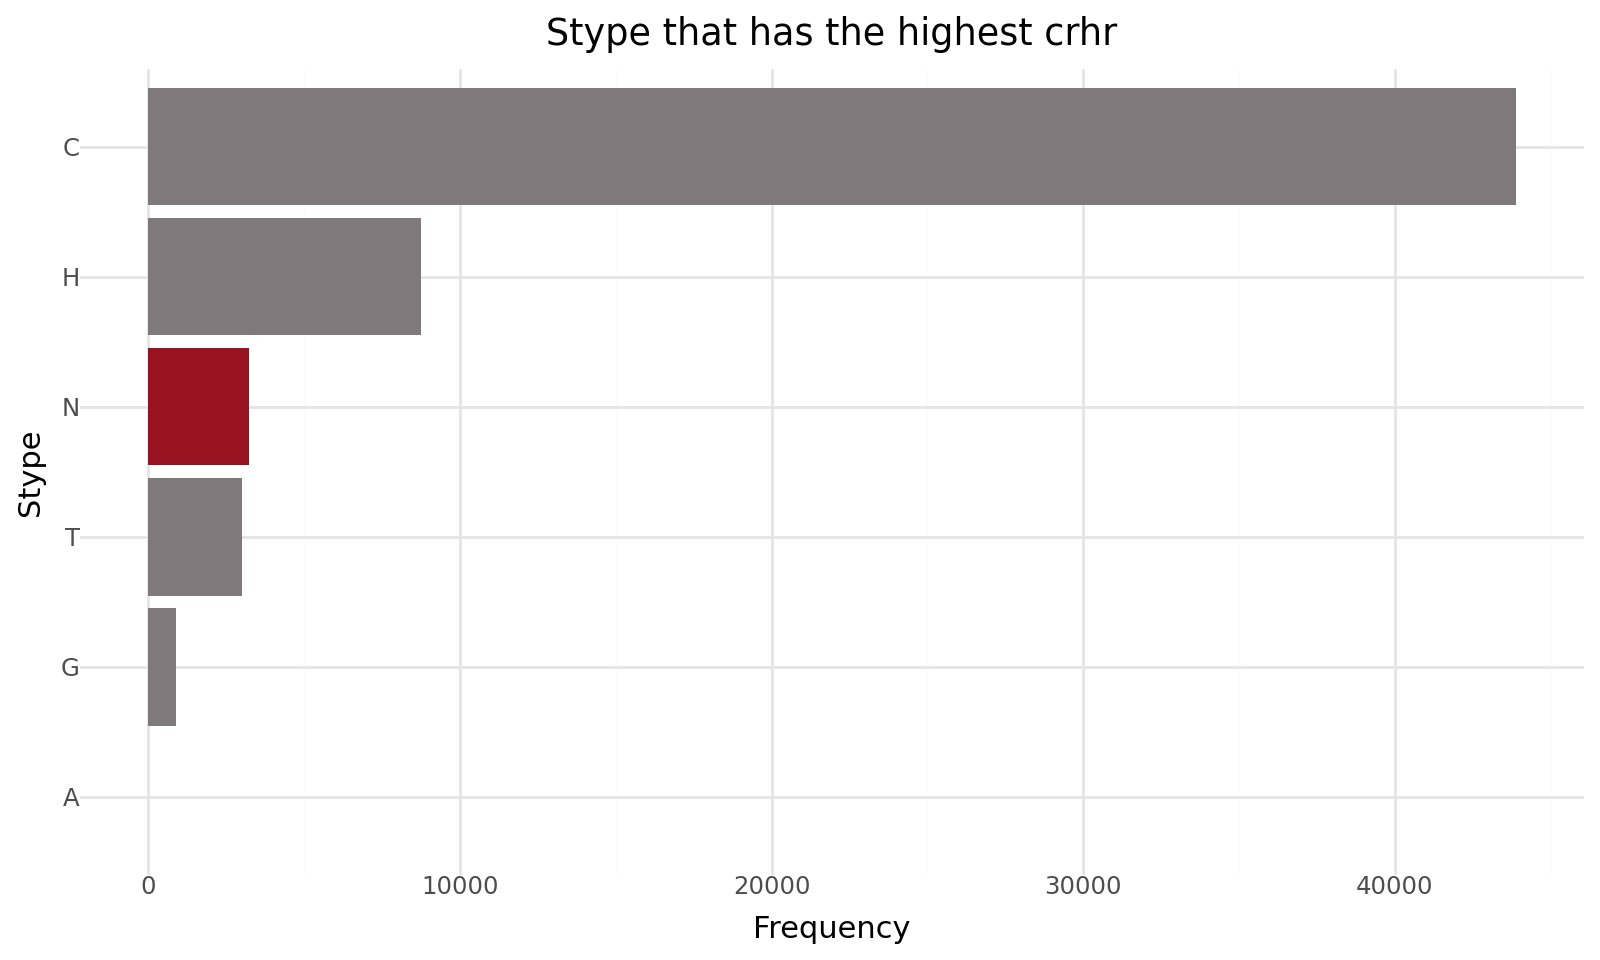

In [38]:
# Plot data. ggplot from R has been imported into Python

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_stype2) + 
      geom_bar(aes(x = 'stype',
                   y = 'totcr'),
               fill = np.where(df_stype2['stype'] == 'N', '#981220', '#80797c'),
               stat = 'identity') + 
      labs(title = 'Stype that has the highest crhr',
           x = 'Stype',
           y = 'Frequency') +
      scale_x_discrete(limits = df_stype2['stype'].tolist()) + 
      theme_minimal() +
      coord_flip()
)

**Standardizing the numerical data**

K-means is sensitive to the scale of the numerical data. Therefore, we will need to standardize *age* and *totcr* because one is on a scale from 0-29 and the other is on a scale from 14-87. 

In [39]:
# The first step is to create a special enrollment dataframe (enroll_sp) 
# that has just the numeric values
enroll_sp = enroll[['id', 'term', 'age', 'totcr']]

In [41]:
from sklearn.preprocessing import StandardScaler

# Initialize standardscaler
std_scaler = StandardScaler()
 
# Standardize the numeric data--*age* and *totcr*
df_scaled = std_scaler.fit_transform(enroll_sp[['age', 'totcr']].to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=['age', 'totcr'])

# Import the ids back into the dataframe for merging
df_scaled['id'] = enroll_sp['id']
 
# Merge the filtered dataframe's categorical variables with the 
# standardized numeric variables.
filt_df = df_scaled.merge(enroll, how = 'left', on = 'id')

# Reorganize the variables and drop the unstandardized age and totcr 
# columns.
filt_df = (filt_df[['id', 'term', 'age_x', 'totcr_x', 'status', 'stype', 'resd_desc', 
                   'degree', 'majr_desc1', 'gender', 'ethn_desc', 'cnty_desc1']]
           .rename(
               columns = {
                   'age_x':'age',
                   'totcr_x':'totcr'
               }
           )
          )

# Finally, drop the duplicate rows that are generated by this merger. I have 
# not figured out why it is duplicating rows (2.28.23)
# These duplications also generate some NaN values that were not there previously.
# Literally just one row of NaN values.
filt_df = (filt_df.drop_duplicates(subset = ['id', 'term'])
               .reset_index(drop = True)
               .drop(['id', 'term'], axis = 1)
               .dropna()
          )

# Finally, for the K-Prototype Algorithm, you have to store the index of the categorical
# columns. That is what we are doing below.
cat_columns_pos = [filt_df.columns.get_loc(i) for i in list(filt_df.select_dtypes('object').columns)]

The K-Prototype clustering algorithm runs best on a matrix, so we want to convert the dataframe (excluding the *id* and *term* column) into a matrix.

In [42]:
# Convert dataframe to matrix
dfmatrix = filt_df.to_numpy()

### Determine Appropriate Number Of Clusters
Now, as is customary to discover the appropriate number of clusters, we will use the *elbow method* to ascertain best number of clusters. Usually, with all numerical data as in the case of K-Means, we would use the within sum of squares errors (WSSE) with Euclidian distance, however, we cannot use Euclidean distance for categorical variables. Therefore, for K-Prototype, we will use the cost function that combines the calculation for numerical and categorical variables. 

In [43]:
# Choose optimal K using the elbow method
cost = []

for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfmatrix, categorical = cat_columns_pos)
        cost.append(kprototype.cost_)
        #print('Cluster Initiation: {}'.format(i))
    except:
        break
    
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 10), 'Cost':cost})

In [44]:
# Look at the % change with each successive K group that is added.
perc_diff = {}

for i in range(1, 9, 1):
    perc_diff[i+1] = (((df_cost['Cost'][i] - df_cost['Cost'][i-1])/df_cost['Cost'][i-1])*100)

(df_cost.merge(pd.DataFrame.from_dict(perc_diff, orient = 'index')
        .reset_index()
        .rename(columns = {'index':'Cluster',
                           0:'% Change'}), how = 'left', on = 'Cluster')
        .fillna("")
)

Cluster      Cost % Change
0        1 23478.027         
1        2 17635.482  -24.885
2        3 13829.856  -21.579
3        4 12300.678  -11.057
4        5 11615.567   -5.570
5        6 10997.011   -5.325
6        7 10545.795   -4.103
7        8 10186.841   -3.404
8        9 10030.118   -1.538

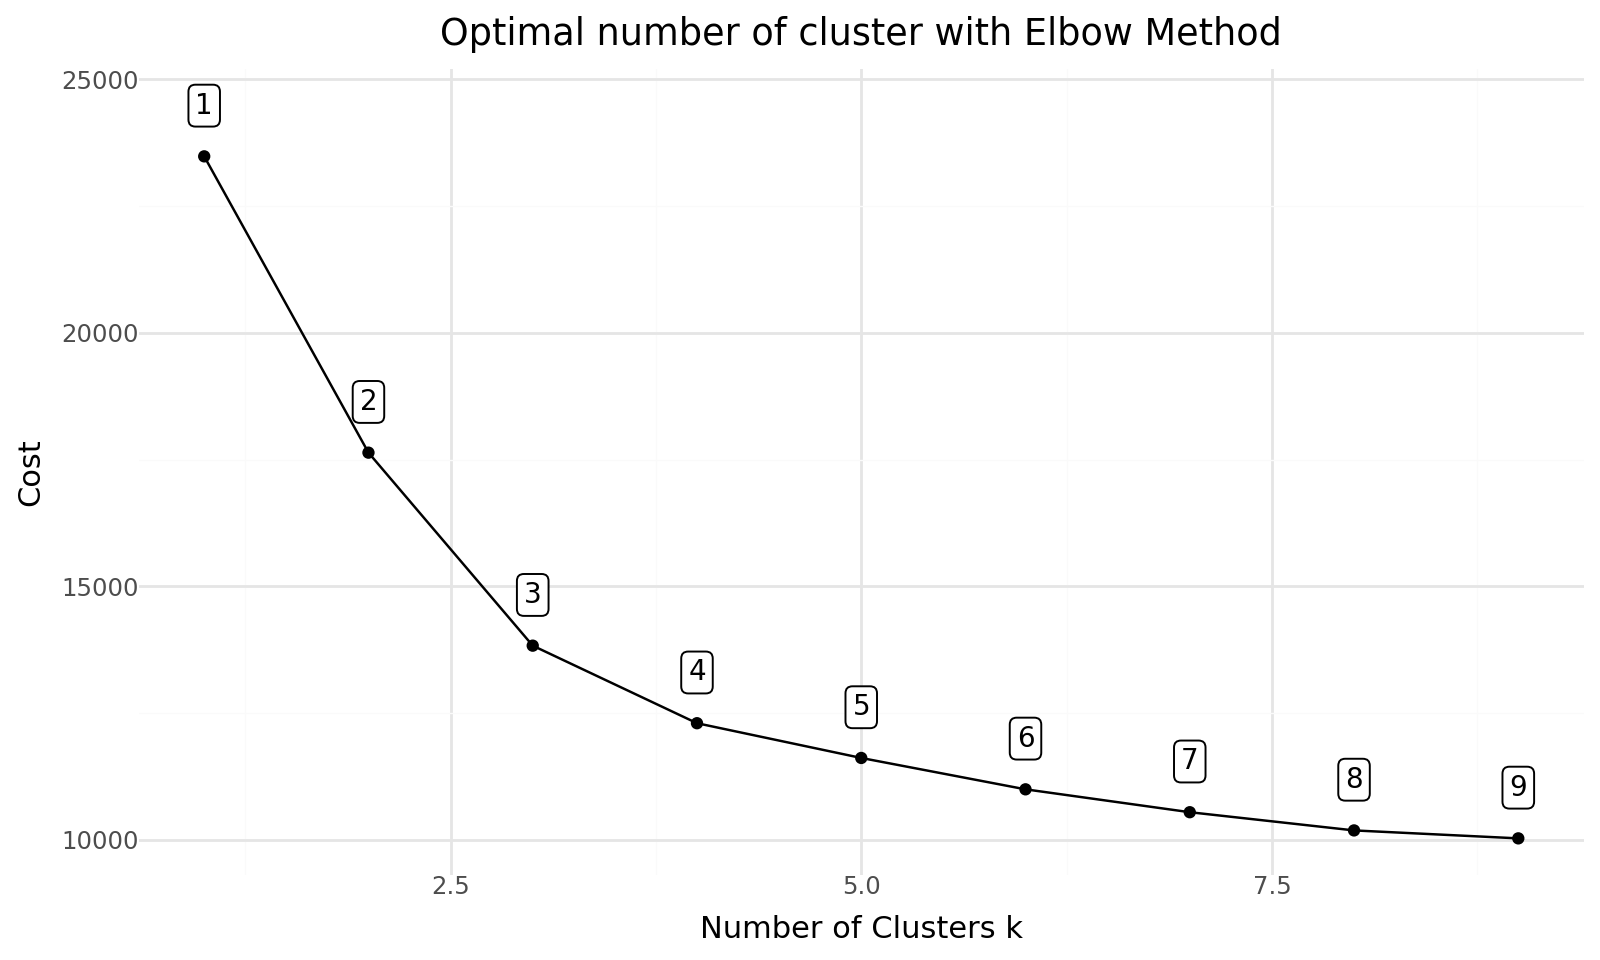

In [45]:
# Create Scree Plot of the Cost function to choose optimal K value
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

Based on the *scree plot* above, we will start with K = 3 as it appears to be the optimal number of clusters. I found this number of clusters to be insufficient for driving insight. Therefore, I played with different number of clusters and found seven to be the optimal number of clusters.

In [46]:
# Fit the clusters
kprototype = KPrototypes(n_jobs = -1, n_clusters = 7, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfmatrix, categorical = cat_columns_pos)

array([5, 2, 6, ..., 6, 1, 1], dtype=uint16)

In [47]:
# cluster centroids
kprototype.cluster_centroids_

# check the iteration of the clusters created
kprototype.n_iter_

# Check the cost of the clusters created
kprototype.cost_

np.float64(10545.794699023165)

### Interpreting The Clusters

In [55]:
# add the clusters to the dataframe
filt_df['id'], filt_df['term'] = enroll_sp['id'], enroll_sp['term']

filt_df['cluster labels'] = kprototype.labels_
filt_df['segment'] = filt_df['cluster labels'].map({0:'First', 1:'Second', 2:'Third'})

# Order clusters
filt_df['segment'] = filt_df['segment'].astype('category')
filt_df['segment'] = filt_df['segment'].cat.reorder_categories(['First', 'Second', 'Third'])

Now we can dig into each cluster to see what characteristics are common between all of them.

In [56]:
# First, create a dataframe with the original ages and total credit hours enrolled
# Essentially destandardizing them.
age_cr = enroll[['id', 'age', 'totcr']].reset_index(drop = True)

# Merge the filtered dataframe with the original ages and credit hours
integrated_clusters = (filt_df.merge(age_cr, how = 'left', on = 'id').drop(['age_x', 'totcr_x'], axis = 1)
                           [['id', 'term', 'age_y', 'totcr_y', 'status', 'stype', 'resd_desc', 
                             'degree', 'majr_desc1', 'gender', 'ethn_desc', 'cnty_desc1', 
                             'cluster labels', 'segment']]
                             .rename(columns = {'age_y':'age',
                                                'totcr_y':'totcr'})
                      )

integrated_clusters1 = integrated_clusters[integrated_clusters['segment'] == 'First']
integrated_clusters2 = integrated_clusters[integrated_clusters['segment'] == 'Second']
integrated_clusters3 = integrated_clusters[integrated_clusters['segment'] == 'Third']

In [57]:
cat_mode = {}
for i in list(integrated_clusters1.select_dtypes('object').columns):
    cat_mode[i] = integrated_clusters1[i].mode()

In [58]:
num_mean = {}

for i in list(integrated_clusters1.select_dtypes('float64').columns):
    num_mean[i] = integrated_clusters1[i].mean()

A quick perusal shows that just looking at the means and modes of these students is not going to be enough to glean anything helpful from each grouping. 

# Plot Longitude And Latitude

This code comes from the website below:

https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec

The code below works splendedly. To make the geospatial clustering useful for our marketing department, I limited the scope to the metro area, which is where the majority of our students come from.

In [63]:
#!pip install folium
#!pip install geopy
#!pip install scikit-learn
#!pip install MiniSom

In [66]:
# Load libraries
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for geospatial
import folium
import geopy

# for machine learning
from sklearn import preprocessing, cluster
import scipy

# for deep learning
import minisom

In [68]:
# Load Dataframe
long_lat = (pd.read_csv('Files/long_lat_202310.csv')
            .rename(columns = str.title)
           )

# Filter dataframe to Wichita and the surrounding area. The cities kept 
# in the filtered data account for ##.##% of all students enrolled for 
# Spring 2023.

long_lat = (long_lat[long_lat['City'].isin(['Wichita', 'El Dorado', 'Andover', 'Derby', 'Augusta', ',Rose Hill',
                                            'Haysville', 'Valley Center', 'Bel Aire', 'Towanda', 'Mulvane', 'Benton',
                                            'Douglass', 'Park City', 'Maize', 'Goddard', 'Kechi'
                                           ]
                                          )
            ]
            .reset_index(drop = True)
           )


In [77]:
# Curtail dataframe to just the Address, Latitude, and Longitude. 
# The new 'count' column is just to create a categorie for the 
# K-Means geospatial algorithm.
long_lat = (pd.DataFrame(long_lat.groupby(['Address', 'Latitude', 'Longitude'])['Address'].count())
              .rename(columns = {'Address':'Count'})
              .reset_index()
           )

category = []

for i in long_lat['Count']:
    if i <= 2:
        category.append('Low')
    elif i >= 3 and i < 7:
        category.append('Med')
    else:
        category.append('High')
        
long_lat['Categories'] = category

#pd.DataFrame(long_lat.groupby('Categories')['Address'].count())

%store long_lat

Stored 'long_lat' (DataFrame)


In [79]:
# Get the coordinates for the city
city = 'Wichita'

# Get location
locator = geopy.geocoders.Nominatim(user_agent = 'MyCoder')
location = locator.geocode(city)
print(location)

# Keep latitude and longitude only
location = [location.latitude, location.longitude]
print('[lat, long]:', location)

%store location

Wichita, Sedgwick County, Kansas, United States
[lat, long]: [37.6922361, -97.3375448]
Stored 'location' (list)


Now *folium* will be used to create a map. It is a convenient package that allows us to plot interactive maps without needing to load a shapefile. Each store shall be identified by a point with size proportional to its current staff and color base on its cost. I'm also going to add a small piece of HTML code to the default map to display the legend.

In [78]:
x, y = 'Latitude', 'Longitude'
color = 'Categories'
size = 'Count'
popup = 'Address'
data = long_lat.copy()

# create color column
lst_colors = ['red', 'green', 'orange']
lst_elements = sorted(list(long_lat[color].unique()))
data['color'] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

%store lst_elements

# create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range = (300, 1000))
data['size'] = scaler.fit_transform(data[size].values.reshape(-1, 1)).reshape(-1)

# Initialize the map with the starting location
map_ = folium.Map(location = location, tiles = 'cartodbpositron', zoom_start = 11)

# add points
data.apply(lambda row: folium.CircleMarker(location = [row[x], row[y]], popup = row[popup],
                                           color = row['color'], fill = True,
                                           size = row['size']).add_to(map_), axis = 1)

# add html legend
legend_html = """<div style = "position:fixed; bottom:10px; left:10px; border:2px solid black; 
                z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b>
                <br>"""

for i in lst_elements:
    legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
                              fa-1x" style = "color:"""+lst_colors[lst_elements.index(i)]+"""">
                              </i>&nbsp;"""+str(i)+"""<br>"""

legend_html = legend_html+"""</div>"""

map_.get_root().html.add_child(folium.Element(legend_html))

# plot the map
map_

Stored 'lst_elements' (list)


### Create Scree Plot To Find Best K

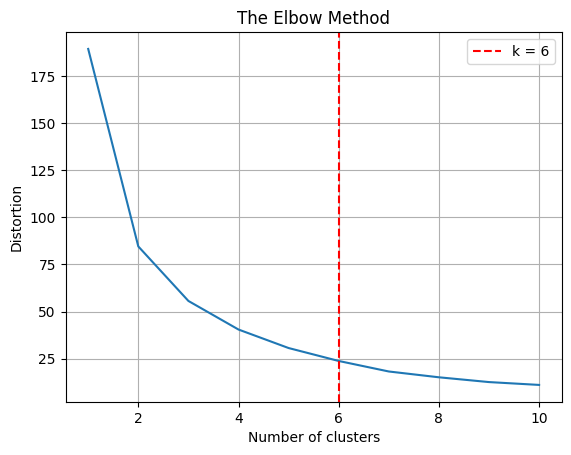

In [74]:
X = long_lat[["Latitude","Longitude"]]
max_k = 10

## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
        model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        model.fit(X)
        distortions.append(model.inertia_)
        
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))

## plot
fig, ax = plt.subplots()

ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)

plt.show()

### Calculate The Distance From Metro Campus For All of Our Students

We use the Haversine formula to calculate the distance from one of our two major Campuses (Andover or El Dorado). If the distance from one of the addresses is closer to Andover than El Dorado, then we store that distance, otherwise we store the distance from El Dorado to the student address. This way, we are storing the shortest distance from the student's home to a major Campus. 

The formula is characterized by:

$$
d = 2r \cdot \arcsin\left(\sqrt{\sin^2\left(\frac{\phi_2 - \phi_1}{2}\right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2\left(\frac{\lambda_2 - \lambda_1}{2}\right)}\right)
$$

Where:
* $d$ is the distance between two points along the surface of the sphere.
* $r$ is the radius of hte sphere (e.g., the Earth's radius).
* $\phi_1$ and $\phi_2$ are the latitudes of the two points in radians.
* $\lambda_1$ and $\lambda_2$ are the longitudes of the two points in radians.
* $\Delta\phi = \phi_2 - \phi_1$ is the difference in latitutes.
* $\Delta\lambda = \lambda_2 - \lambda_1$ is the difference in longitudes.

In [ ]:
import pandas as pd
import numpy as np
from processing import calculate_distance

# Fixed point coordinates
andover_lat = 37.7062631  # Andover BCC Latitude
andover_lon = -97.1276288 # Andover BCC longitude
eldo_lat = 37.8073112 # Eldo BCC Latitude
eldo_lon = -96.8851877 # Eldo BCC Longitude

# Read csv file into a pandas DataFrame
df = pd.read_csv('K-Means_202310.csv')

# Calculate distance from fixed point for each row
df['Distance'] = np.vectorize(calculate_distance)(andover_lat, andover_lon, df['Latitude'], df['Longitude'], eldo_lat, eldo_lon)

# Print DataFrame with Distance to folder
df.to_csv('K-Means_202310_distance.csv', index = False, header = True)